<img src="../../thumbnail.png" width=500 alt="Kerchunk Logo"></img>



# Basics of virtual Zarr stores

## Overview

This notebook is intended as an introduction to creating and using virtual Zarr stores.
In this tutorial we will:
- Scan a single NetCDF4/HDF5 file to create a virtual dataset
- Learn how to use the output using `Xarray` and `Zarr`.

While this notebook only examines using `VirtualiZarr` and `Kerchunk` on a single NetCDF file, these libraries can be used to create virtual `Zarr` datasets from collections of many input files. In the following notebook, we will demonstrate this. 

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Helpful | Basic features |

- **Time to learn**: 60 minutes
---

## Imports

Here we will import a few `Python` libraries to help with our data processing. 
- `virtualizarr` will be used to generate the virtual Zarr store
- `Xarray` for examining the output dataset


In [1]:
import xarray as xr
from virtualizarr import open_virtual_dataset

### Define storage_options arguments

In the dictionary definition in the next cell, we are defining the options that will be passed to [`fsspec.open`](https://filesystem-spec.readthedocs.io/en/latest/api.html?highlight=.open#fsspec.open). Any additional kwargs passed in this dictionary through `fsspec.open` will pass as kwargs to the file system, in our case `s3`. The API docs for the `s3fs` filesystem spec can be found [here](https://s3fs.readthedocs.io/en/latest/api.html).

In this example we are passing a few kwargs. In short they are:
- `anon=True`: This is a `s3fs` kwarg that specifies you are not passing any connection credentials and are connecting to a public bucket.
- `default_fill_cache=False`: `s3fs` kwarg that avoids caching in between chunks of files. This may lower memory usage when reading large files.
- `default_cache_type="first"`: `fsspec` kwarg that specifies the caching strategy used by `fsspec`. In this case, `first` caches the first block of a file only.

Don't worry too much about the details here; the cache options are those that have typically proven efficient for HDF5 files. 

In [2]:
storage_options = dict(anon=True, default_fill_cache=False, default_cache_type="first")

### Virtualize a single NetCDF file

Below we will virtualize a NetCDF file stored on the AWS cloud. This dataset is a single time slice of a climate downscaled product for Alaska.

The steps in the cell below are as follows:
1. Create a virtual dataset using `open_virtual_dataset`
1. Write the virtual store as a Kerchunk reference JSON using the `to_kerchunk` method.


In [3]:
# Input URL to dataset. Note this is a netcdf file stored on s3 (cloud dataset).
url = "s3://wrf-se-ak-ar5/ccsm/rcp85/daily/2060/WRFDS_2060-01-01.nc"


# Create a virtual dataset using VirtualiZarr.
# We specify `indexes={}` to avoid creating in-memory pandas indexes for each 1D coordinate, since concatenating with pandas indexes is not yet supported in VirtualiZarr
virtual_ds = open_virtual_dataset(
    url, indexes={}, reader_options={"storage_options": storage_options}
)
# Write the virtual dataset to disk as a Kerchunk JSON. We could alternative write to a Kerchunk JSON or Icechunk Store.
virtual_ds.virtualize.to_kerchunk("single_file_kerchunk.json", format="json")

### Opening virtual datasets

In the section below we will use the previously created `Kerchunk` reference JSON to open the `NetCDF` file as if it were a `Zarr` dataset.

In [4]:
# We once again need to provide information for fsspec to access the remote file
storage_options = dict(
    remote_protocol="s3", remote_options=dict(anon=True), skip_instance_cache=True
)
# We will use the "kerchunk" engine in `xr.open_dataset` and pass the `storage_options` to the `kerchunk` engine through `backend_kwargs`
ds = xr.open_dataset(
    "single_file_kerchunk.json",
    engine="kerchunk",
    backend_kwargs={"storage_options": storage_options},
)
ds

<xarray.Dataset> Size: 31MB
Dimensions:        (Time: 1, south_north: 250, west_east: 320,
                    interp_levels: 9, soil_layers_stag: 4)
Coordinates:
  * Time           (Time) datetime64[ns] 8B NaT
    XLAT           (south_north, west_east) float32 320kB ...
    XLONG          (south_north, west_east) float32 320kB ...
  * interp_levels  (interp_levels) float32 36B 100.0 200.0 300.0 ... 925.0 1e+03
Dimensions without coordinates: south_north, west_east, soil_layers_stag
Data variables: (12/37)
    ACSNOW         (Time, south_north, west_east) float32 320kB ...
    ALBEDO         (Time, south_north, west_east) float32 320kB ...
    CLDFRA         (Time, interp_levels, south_north, west_east) float32 3MB ...
    GHT            (Time, interp_levels, south_north, west_east) float32 3MB ...
    HFX            (Time, south_north, west_east) float32 320kB ...
    LH             (Time, south_north, west_east) float32 320kB ...
    ...             ...
    U              (Time, interp_levels, south_north, west_east) float32 3MB ...
    U10            (Time, south_north, west_east) float32 320kB ...
    V              (Time, interp_levels, south_north, west_east) float32 3MB ...
    V10            (Time, south_north, west_east) float32 320kB ...
    lat            (south_north, west_east) float32 320kB ...
    lon            (south_north, west_east) float32 320kB ...
Attributes:
    contact:  rtladerjr@alaska.edu
    data:     Downscaled CCSM4
    date:     Mon Oct 21 11:37:23 AKDT 2019
    format:   version 2
    info:     Alaska CASC

### Plot dataset

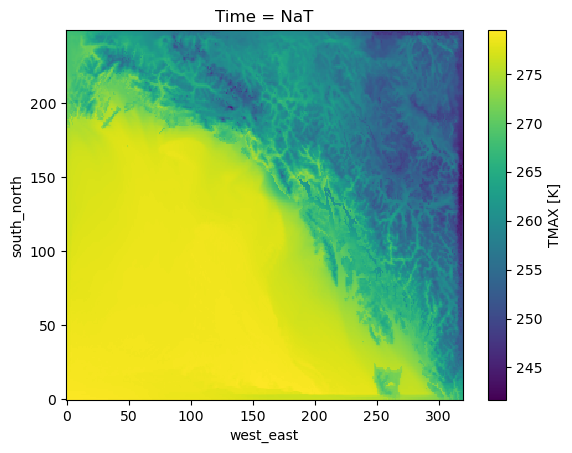

In [5]:
ds.TMAX.plot()

Note that the original .nc file size here is 16.8MB, and the created JSON is 26.5kB. These files also tend to compress very well. As you can see, it the JSON can be written anywhere, and gives us access to the underlying data, reading only the chunks we need from remote without downloading the whole file.